# Classify gestures by reading muscle activity

# 실험 요약

# 선정한 데이터 설명 및 데이터 출처

사람이 근육을 사용하여 몸을 움직일 때는 근전도(EMG)라는 것이 발생한다. 근전도는 근육에 있는 신경섬유에서 나오는 전기적 신호들이 합쳐져 발생하며, 이를 통해 근육의 상태나 행동 특징에 대해 파악할 수 있다. 최근의 연구 결과를 살펴보면, 일반적인 근육의 상태나 움직임을 파악할 수 있는 것뿐만 아니라 근육 관련 질환, 나아가 파킨슨병까지 진단할 수 있다고 한다. 최근에는 MYO라는 간편한 휴대용 근전도 기록 기기가 나와 보다 간편하게 application을 만들 수 있게 되었다. 

이번 기말과제에서 선정한 데이터는 Kaggle에 공개된 데이터셋, 'Classify gestures by reading muscle activity: a recording of human hand muscle activity producing four different hand gestures' (https://www.kaggle.com/kyr7plus/emg-4/home) 다. 데이터 자체가 흥미로울 뿐만 아니라 추후 다양한 어플리케이션, 특히 헬스케어 등 다양한 분야로 확장할 수 있다는 점이 매력적으로 느껴져 기말과제 주제로 선정하였다. 또한 공간적, 시간적으로 의미가 있는 데이터인 것 같아 기존의 머신러닝 모델뿐만 아니라 해당 특징을 가진 데이터에 효과적인 딥러닝 모델을 적용할 때 성능이 어떻게 나올지 궁금하기도 했다.

이 데이터셋은 MYO라는 근전도 기록 기기로 4가지의 손동작(가위, 바위, 보, ok)을 기록한 데이터들로 이루어져 있다. 8개의 센서가 8개의 연속된 시점으로 기록되어, 하나의 instance당 64개의 feature를 가지고 있다. 각 class당 약 2900개 내외의 데이터를 가지고 있어 총 11,678개의 instance가 데이터셋으로 공개되었다. 각 데이터는 200 Hz로 기록되었는데 이는 40ms의 단위로 기록되었음을 의미한다.

데이터 형식은 아래와 같이 주어진다.

[8sensors][8sensors][8sensors][8sensors][8sensors][8sensors][8sensors][8sensors][GESTURE_CLASS]

그리고 gesture class는 rock - 0, scissors - 1, paper - 2, ok - 3로 주어진다.

따라서 이 기말과제의 목적은 EMG 데이터를 활용하여 손동작 클래스를 구분하는 Classification 문제를 푸는 것이다.

# 실험 설계 및 방법

    • 자신이 선정한 모델 및 모델 선정에 대한 이유
    • 분석에 시도한 trial 및 error 에 대한 설명(초기 모델에서 기대 이하의 성능이 나올 경우, 모델의 설정에 다양한 변화를 주고 validation 을 통해 개선되는 점을 보여줄 것)
    • Data set 을 train-set, validation-set, test-set 으로 구분하여 사용하며, 최종 모델 평가는 test-set 을 통해 평가
    • 실험 설계 및 평가 분석에 overfitting 의 관점이 사용되어야 함.

## 라이브러리 불러오기 

In [54]:
# 전처리, 자료형, 시각화 라이브러리
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [59]:
# 머신러닝 모델 라이브러리
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
import keras

In [62]:
# 데이터 전처리
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import RFE

## 데이터 불러오기 

In [5]:
# load csv files by class
data_rock = pd.read_csv('./emg-4/0.csv',header=None)
data_scissors = pd.read_csv('./emg-4/1.csv',header=None)
data_paper = pd.read_csv('./emg-4/2.csv',header=None)
data_ok = pd.read_csv('./emg-4/3.csv',header=None)

In [6]:
data = pd.concat([data_rock,data_scissors,data_paper,data_ok],axis=0,ignore_index=True) # 데이터 통합하기

## 데이터 탐색 

데이터의 특징을 간단하게 알아보고 및 preprocessing을 진행하기 위해, 데이터 탐색을 진행한다.

### data.info() 

data.info() 함수를 통해 각 column의 데이터 개수, null 여부, 자료형을 확인한다.

In [30]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11678 entries, 0 to 11677
Data columns (total 65 columns):
0     11678 non-null float64
1     11678 non-null float64
2     11678 non-null float64
3     11678 non-null float64
4     11678 non-null float64
5     11678 non-null float64
6     11678 non-null float64
7     11678 non-null float64
8     11678 non-null float64
9     11678 non-null float64
10    11678 non-null float64
11    11678 non-null float64
12    11678 non-null float64
13    11678 non-null float64
14    11678 non-null float64
15    11678 non-null float64
16    11678 non-null float64
17    11678 non-null float64
18    11678 non-null float64
19    11678 non-null float64
20    11678 non-null float64
21    11678 non-null float64
22    11678 non-null float64
23    11678 non-null float64
24    11678 non-null float64
25    11678 non-null float64
26    11678 non-null float64
27    11678 non-null float64
28    11678 non-null float64
29    11678 non-null float64
30    11678 non-null 

### data.describe() 

data.describe() 함수를 통해 데이터의 평균, 표준편차, 최소/최대값, 4분위값을 알아본다.

In [32]:
data.describe()

,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,64
count,11678.000000,11678.000000,11678.000000,11678.000000,11678.000000,11678.000000,11678.000000,11678.000000,11678.000000,11678.000000,...,11678.000000,11678.000000,11678.000000,11678.000000,11678.000000,11678.000000,11678.000000,11678.000000,11678.000000,11678.000000
mean,-0.520380,-0.726837,-0.739082,-0.729748,-0.159103,-0.554890,-1.272649,-0.661843,-0.665953,-0.654222,...,-0.932694,-0.836958,-0.740623,-0.768710,-0.705343,-0.146686,-0.374807,-1.449306,-0.609094,1.503254
std,18.566709,11.766878,4.989944,7.441675,17.850402,25.809528,25.089972,15.408896,18.123854,11.841260,...,15.158993,18.204465,12.005206,4.969758,7.384410,17.841479,25.551082,25.259736,15.530091,1.117541
min,-116.000000,-104.000000,-33.000000,-75.000000,-121.000000,-122.000000,-128.000000,-128.000000,-110.000000,-128.000000,...,-128.000000,-116.000000,-128.000000,-46.000000,-74.000000,-103.000000,-128.000000,-128.000000,-124.000000,0.000000
25%,-9.000000,-4.000000,-3.000000,-4.000000,-10.000000,-15.000000,-6.000000,-8.000000,-9.000000,-4.000000,...,-8.000000,-9.000000,-4.000000,-3.000000,-4.000000,-10.000000,-14.000000,-6.000000,-8.000000,1.000000
50%,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,-1.000000,-1.000000,-1.000000,2.000000
75%,7.000000,3.000000,2.000000,3.000000,10.000000,13.000000,4.000000,6.000000,6.000000,3.000000,...,6.000000,6.000000,3.000000,2.000000,3.000000,10.000000,13.000000,3.000000,6.000000,3.000000
max,111.000000,90.000000,34.000000,55.000000,92.000000,127.000000,127.000000,126.000000,127.000000,106.000000,...,114.000000,127.000000,105.000000,29.000000,51.000000,110.000000,127.000000,127.000000,127.000000,3.000000


### Histogram 그리기 

64개의 feature의 분포에 대해 Label별로 색깔을 정해(파랑-바위, 주황-가위, 초록-보, 빨강-ok) Histogram을 그려 시각화.

8x8 배열에서 row는 8개의 연속된 시점, column은 8개의 sensor로 생각하면 된다.

대부분 정규분포를 따르고 있는 것으로 보이며, outlier는 크게 보이지 않는다.

다만 7번째 sensor에서 바위 class의 deviation이 큰 것으로 관찰되어, 이 부분은 rule-based로 잘 구분할 수 있을 것으로 예상된다.

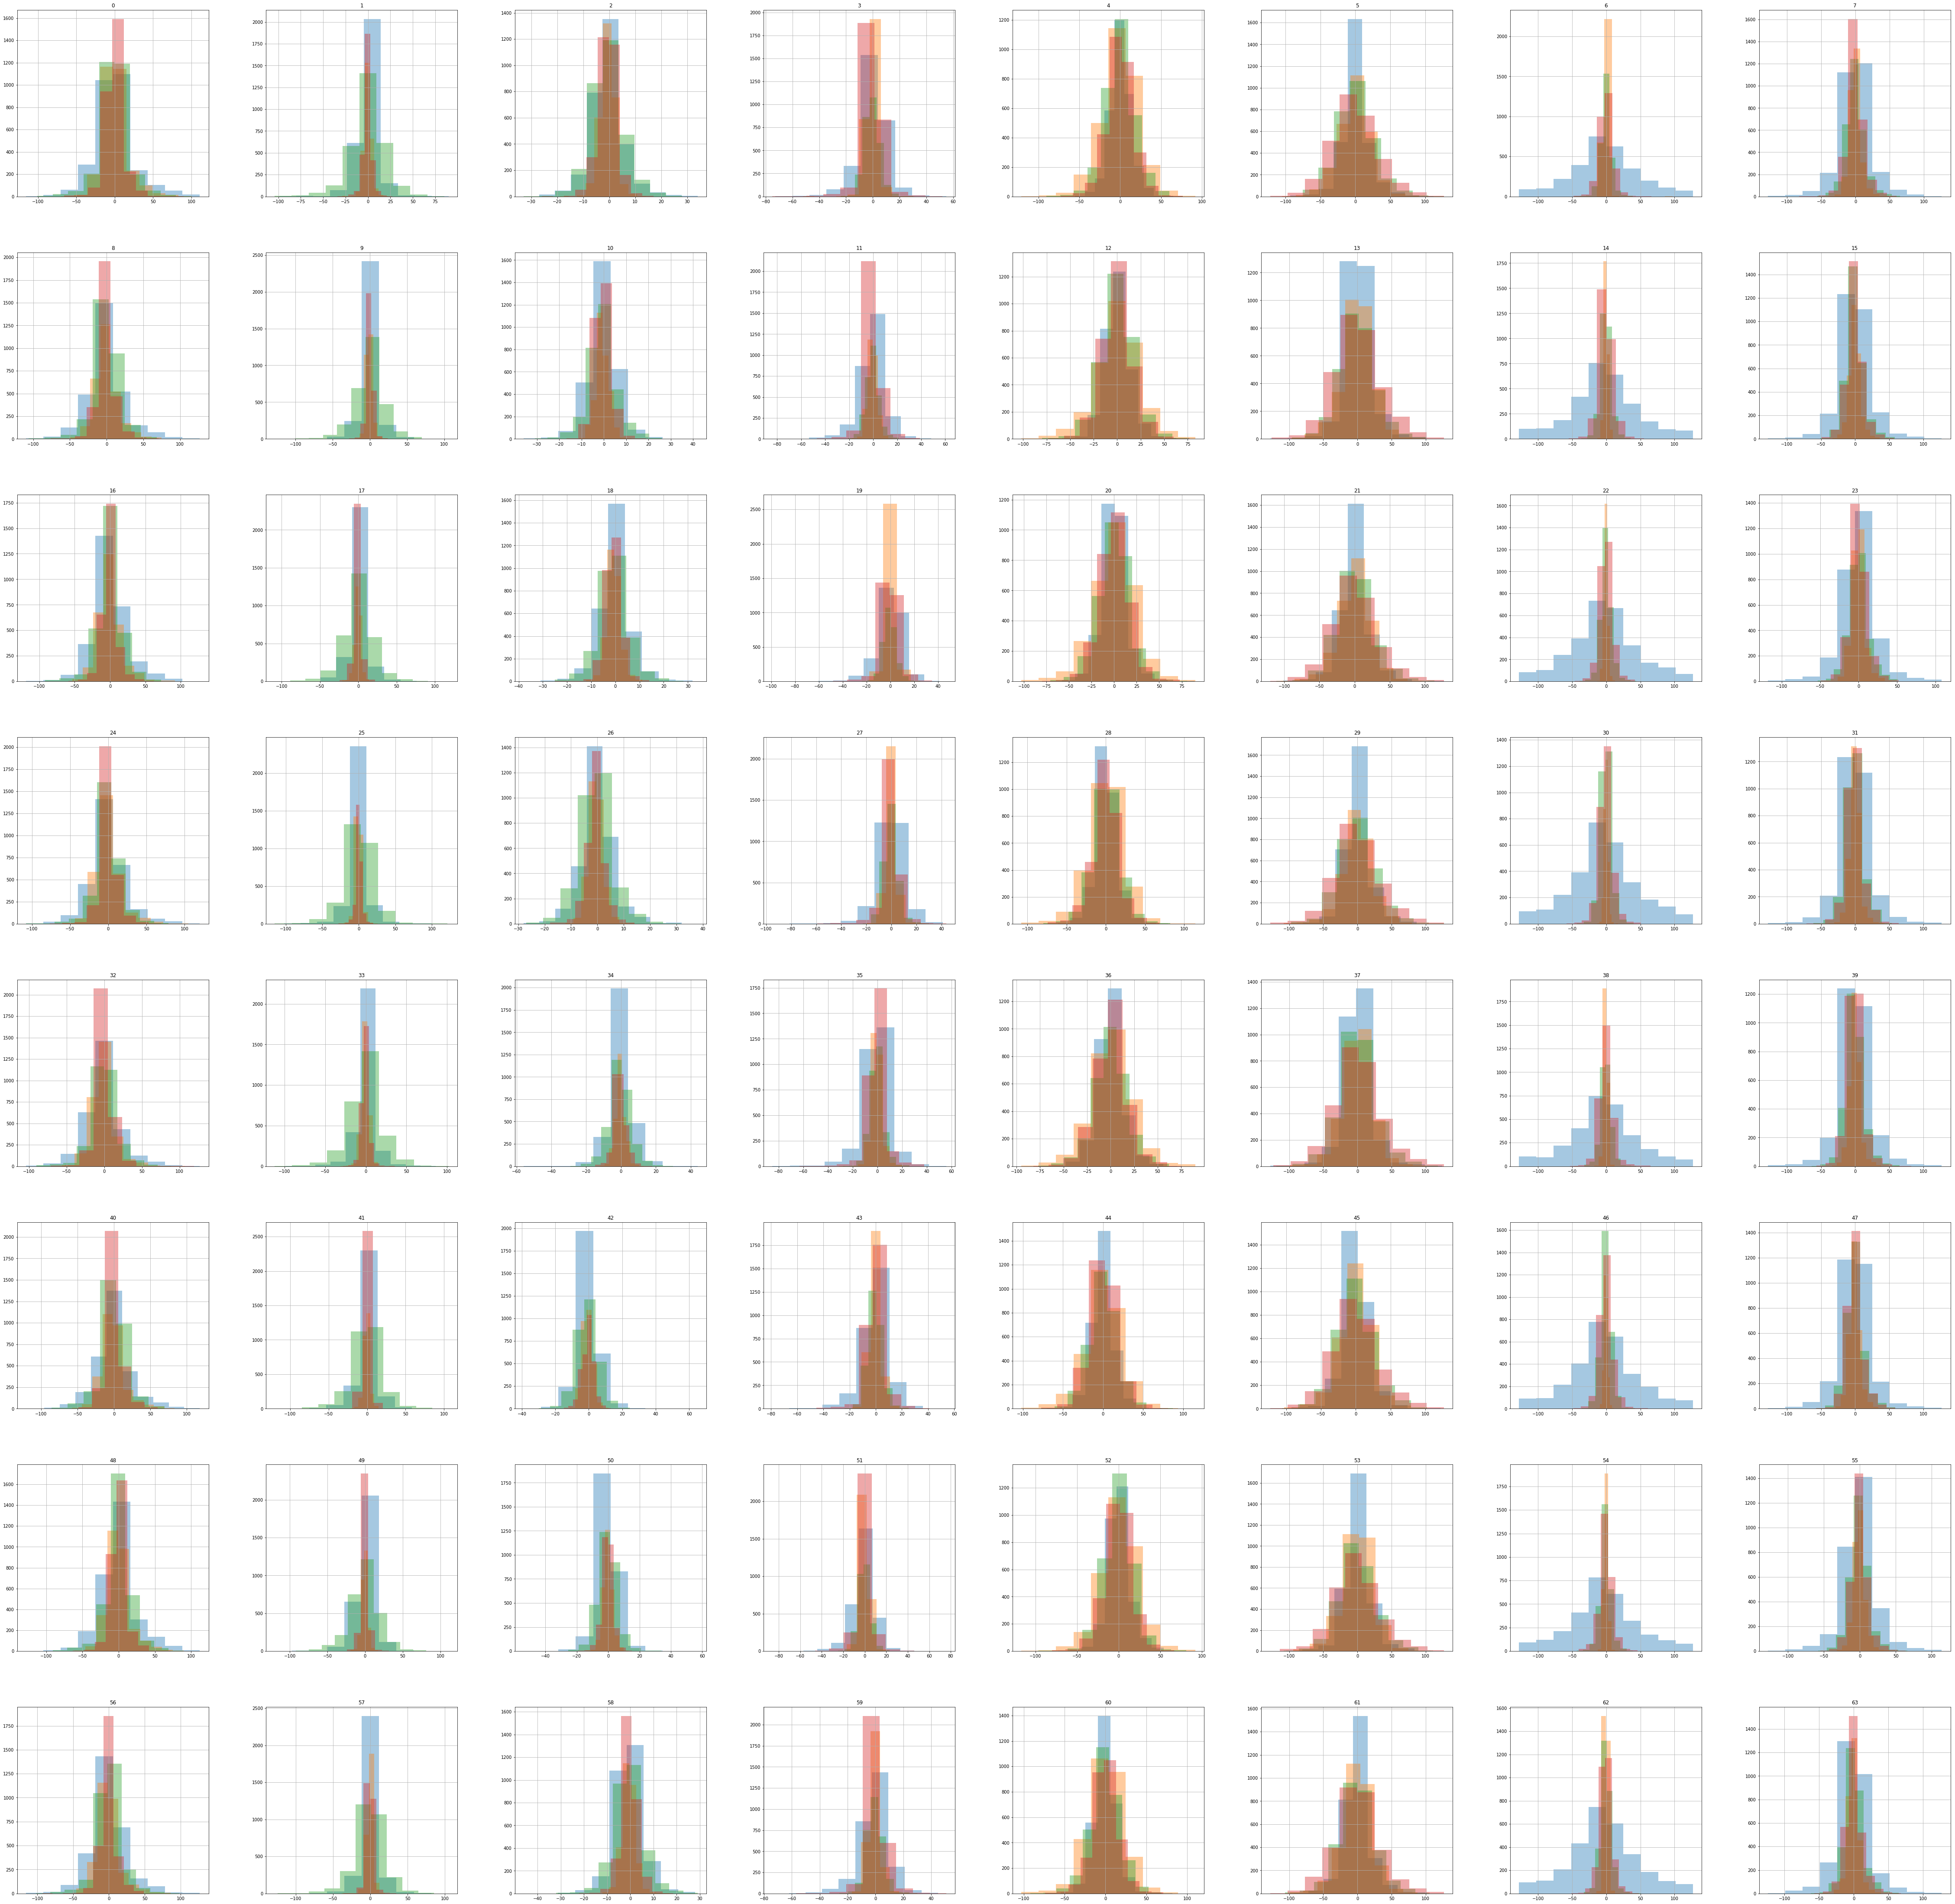

In [53]:
fig, axes = plt.subplots(8,8,figsize=(80,80))
for i in range(0,8):
    for j in range(0,8):
        data[[i*8+j,64]].groupby(64).hist(alpha=0.4,ax=axes[i][j])

plt.show()

## 데이터 train / test / validation 나누기 

60:20:20의 비율로 train / test / validation set을 나누었다.

In [73]:
X_train, X_, y_train, y_ = train_test_split(data.iloc[:,:64], data[64], test_size=0.4, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_, y_, test_size=0.5, random_state=42)

In [74]:
X_train.shape

(7006, 64)

In [75]:
X_test.shape

(2336, 64)

In [76]:
X_val.shape

(2336, 64)

In [77]:
y_train.shape

(7006,)

In [78]:
y_test.shape

(2336,)

In [79]:
y_val.shape

(2336,)

# 실험-모델 적용 

## Baseline

In [93]:
baseline_stratified = DummyClassifier("stratified")
baseline_most_frequent = DummyClassifier("most_frequent")
baseline_uniform = DummyClassifier("uniform")

In [94]:
baseline_stratified.fit(X_train,y_train)
baseline_most_frequent.fit(X_train,y_train)
baseline_uniform.fit(X_train,y_train)
print("baseline - stratified acc:",baseline_stratified.score(X_val,y_val))
print("baseline - most frequent acc:",baseline_most_frequent.score(X_val,y_val))
print("baseline - uniform acc:",baseline_uniform.score(X_val,y_val))

baseline - stratified acc: 0.2525684931506849
baseline - most frequent acc: 0.2512842465753425
baseline - uniform acc: 0.24529109589041095


In [ ]:
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
import keras

## K Neigherest Neighbor 

In [96]:
knn_classifier = KNeighborsClassifier()
knn_classifier.fit(X_train,y_train)
print("K Neigherest Neighbor acc:",knn_classifier.score(X_val,y_val))

K Neigherest Neighbor acc: 0.6772260273972602


## Support Vector Machine 

In [101]:
svm_classifier = SVC()
svm_classifier.fit(X_train,y_train)
print("Support Vector Machine acc:",svm_classifier.score(X_val,y_val))

/Users/karl/miniconda3/lib/python3.5/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Support Vector Machine acc: 0.24743150684931506


## Decision Tree 

In [99]:
DT_classifier = DecisionTreeClassifier()
DT_classifier.fit(X_train,y_train)
print("Decition Tree acc:",DT_classifier.score(X_val,y_val))

Decition Tree acc: 0.7611301369863014


## Random Forest 

In [100]:
RF_classifier = RandomForestClassifier()
RF_classifier.fit(X_train,y_train)
print("Random Forest acc:",RF_classifier.score(X_val,y_val))

/Users/karl/miniconda3/lib/python3.5/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Random Forest acc: 0.8728595890410958


## Naïve Bayes

In [95]:
nb_classifier = GaussianNB()
nb_classifier.fit(X_train,y_train)
print("Naïve Bayes acc:",nb_classifier.score(X_val,y_val))

Naïve Bayes acc: 0.8728595890410958


## Multilayer Perceptron 

In [102]:
mlp_classifier = MLPClassifier()
mlp_classifier.fit(X_train,y_train)
print("Multilayer Perceptron acc:",mlp_classifier.score(X_val,y_val))

Multilayer Perceptron acc: 0.9096746575342466


## CNN 

In [133]:
import keras.backend as K
from keras import models
from keras import layers
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import to_categorical

In [153]:
def alexnet_variation(input_shape, n_classes):
    model = models.Sequential()
    
    model.add(layers.Conv2D(32,(3,3),activation='relu',padding='same',input_shape=input_shape))
    model.add(layers.Conv2D(64,(3,3),activation='relu',padding='same'))
    model.add(layers.Conv2D(128,(3,3),activation='relu',padding='same'))
    model.add(layers.Conv2D(256,(3,3),activation='relu',padding='same'))
    model.add(layers.Conv2D(512,(3,3),activation='relu',padding='same'))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(128,activation='relu'))
    model.add(layers.Dense(128,activation='relu'))
    model.add(layers.Dense(n_classes,activation='softmax'))
    
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc'])
    model.summary()
    return model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_37 (Conv2D)           (None, 8, 8, 32)          320       
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 8, 8, 64)          18496     
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 8, 8, 128)         73856     
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 8, 8, 256)         295168    
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 8, 8, 512)         1180160   
_________________________________________________________________
flatten_6 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_13 (Dense)             (None, 128)               4194432   
__________

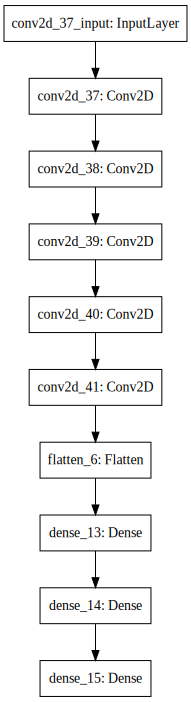

In [154]:
cnn = alexnet_variation(input_shape=(8,8,1),n_classes=4)
SVG(model_to_dot(cnn).create(prog='dot', format='svg'))

In [ ]:
y_train_DL = to_categorical(y_train)
y_val_DL = to_categorical(y_val)
y_test_DL = to_categorical(y_test)
X_train_CNN = np.array(X_train).reshape(X_train.shape[0],8,8,1)
X_val_CNN = np.array(X_val).reshape(X_val.shape[0],8,8,1)
X_test_CNN = np.array(X_test).reshape(X_test.shape[0],8,8,1)

In [ ]:
cnn.fit(X_train_CNN,y_train_DL,epochs=100,batch_size=2048)

Epoch 1/100
2048/7006 [=======>......................] - ETA: 66s - loss: 1.2166 - acc: 0.3770

## RNN 

## LSTM 

## CNN-LSTM 

## 결론